In [27]:
import pandas as pd
import numpy as np

train_df = pd.read_csv('train.tsv', sep='\t')
val_df = pd.read_csv('val.tsv', sep='\t')

In [28]:
train_df['english_text'].isnull().sum()

0

In [29]:
val_df['english_text'].isnull().sum()

0

In [30]:
print('Train Bullying:', train_df[train_df['bully']==1].shape[0])
print('Train NotBullying:', train_df[train_df['bully']==0].shape[0])

print('Val Bullying:', val_df[val_df['bully']==1].shape[0])
print('Val NotBullying:', val_df[val_df['bully']==0].shape[0])

Train Bullying: 1013
Train NotBullying: 909
Val Bullying: 221
Val NotBullying: 260


In [31]:
train_df[train_df['bully']==1].sample(n=1)['english_text'].iloc[0]

'stupid boys and girls'

In [32]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

In [33]:
stop_words = stopwords.words('english')
stop_words.remove('not')
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [34]:
def data_preprocessing(review):
    
    # data cleaning
    review = re.sub(re.compile('<.*?>'), '', review) # remove html tags
    review = re.sub('[^A-Za-z0-9]+', ' ', review) # taking only words
    
    # lowercase
    review = review.lower()
    
    # tokenization
    tokens = nltk.word_tokenize(review)
    
    # stop word removal
    review = [word for word in tokens if word not in stop_words]
    
    # lemmatization
    review = [lemmatizer.lemmatize(word) for word in review]
    
    # stemming
    review = [stemmer.stem(word) for word in review]
    
    # join words in preprocessed review
    review = ' '.join(review)
    
    return review

In [35]:
train_df['preprocessed_text'] = train_df['english_text'].apply(lambda review: data_preprocessing(review))
train_df

,english_text,bully,preprocessed_text
0,I would have gave 10 hahah react is possible,1,would gave 10 hahah react possibl
1,Ayman brother,0,ayman brother
2,"Hair show, all the nonsense, they follow the c...",1,hair show nonsens follow cultur pagan muslim n...
3,I get a lot of motivations in the words of the...,0,get lot motiv word brother
4,"Brother, Bismillah before the meal did not say...",0,brother bismillah meal not say
...,...,...,...
1917,I don't think anyone can do it better than him...,1,think anyon better oscar given
1918,direty,1,direti
1919,Alhamdulillah!God guides!,0,alhamdulillah god guid
1920,See Jessie's hip?????,1,see jessi hip


In [36]:
val_df['preprocessed_text'] = val_df['english_text'].apply(lambda review: data_preprocessing(review))
val_df

,english_text,bully,preprocessed_text
0,They are full of food and drink,1,full food drink
1,funny,1,funni
2,2 dirty and one athesit talking,1,2 dirti one athesit talk
3,"The more you listen to your words, and find th...",0,listen word find mean life
4,"Well, bro, a video of your game came out, is i...",1,well bro video game came true fals
...,...,...,...
476,Really beautiful,0,realli beauti
477,For a long time I have been waiting for this v...,1,long time wait vander someon lenga alhamdulill...
478,Freedom fighter,0,freedom fighter
479,These clocks certainly forced the BNP Jamaat t...,0,clock certainli forc bnp jamaat forc behind co...


In [37]:
X_train = train_df['preprocessed_text']
X_val = val_df['preprocessed_text']

y_train = train_df['bully']
y_val = val_df['bully']

print('Train data:', X_train.shape, y_train.shape)
print('Test data:', X_val.shape, y_val.shape)

Train data: (1922,) (1922,)
Test data: (481,) (481,)


In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer


# Use TfidfVectorizer for TF-IDF encoding
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

print('X_train shape (TF-IDF):', X_train_tfidf.shape)
print('X_val shape (TF-IDF):', X_val_tfidf.shape)

X_train shape (TF-IDF): (1922, 2995)
X_val shape (TF-IDF): (481, 2995)


In [50]:
import pickle
vectorizer_filename = 'Model/tfidf_vectorizer.sav'
with open(vectorizer_filename, 'wb') as filehandler:
    pickle.dump(tfidf_vectorizer, filehandler)

Naive Bayes Model Performance:
Best Parameters: {'alpha': 0.5}
Accuracy: 0.8087318087318087
Precision: 0.8154830735811163
Recall: 0.8087318087318087
F1 Score: 0.8089550983013453


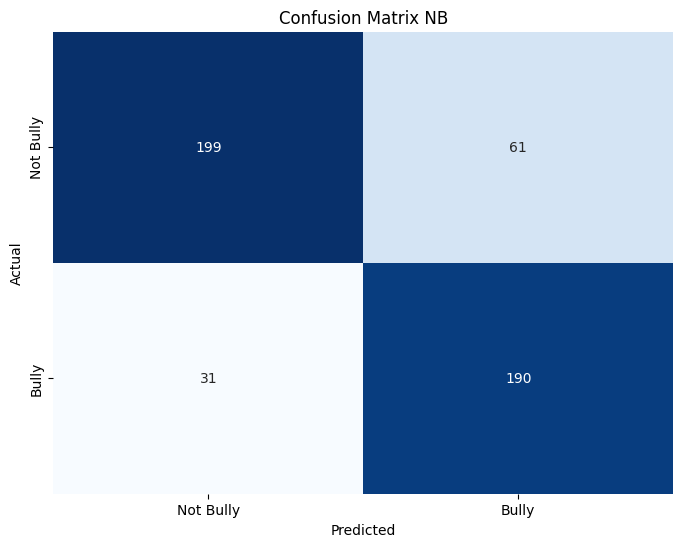

In [39]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Define the parameter grid for grid search
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0], 
}

# Create a Naive Bayes classifier
nb_classifier = MultinomialNB()

# Create a GridSearchCV object
grid_search = GridSearchCV(nb_classifier, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train_tfidf, y_train)

# Get the best estimator from the grid search
best_nb_classifier = grid_search.best_estimator_

# Make predictions on the validation set
y_val_pred = best_nb_classifier.predict(X_val_tfidf)

# Evaluate performance
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred, average='weighted')
recall = recall_score(y_val, y_val_pred, average='weighted')
f1 = f1_score(y_val, y_val_pred, average='weighted')

# Print the results
print("Naive Bayes Model Performance:")
print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Plot Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Bully', 'Bully'],
            yticklabels=['Not Bully', 'Bully'])
plt.title('Confusion Matrix NB')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


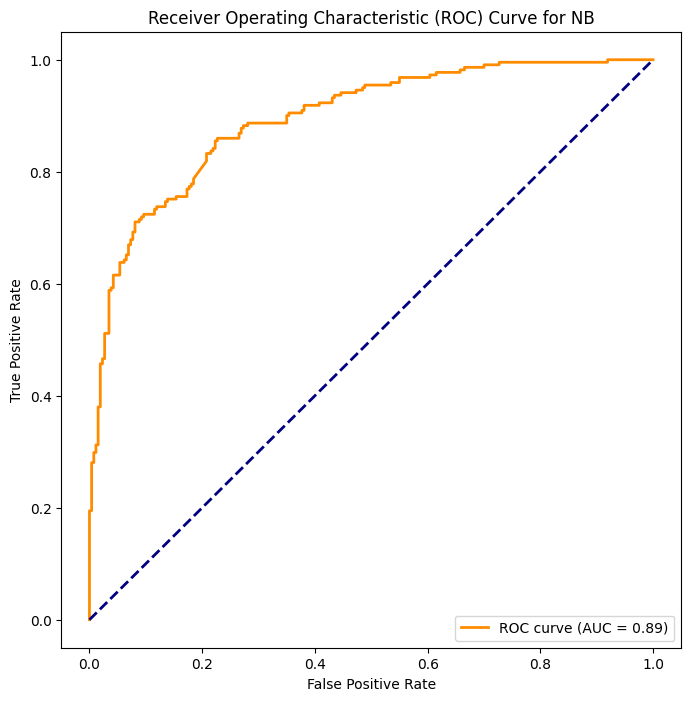

AUC (NB): 0.8944135050469891


In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for the positive class
y_val_prob = best_nb_classifier.predict_proba(X_val_tfidf)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_val, y_val_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for NB')
plt.legend(loc='lower right')
plt.show()

print("AUC (NB):", roc_auc)


Decision Tree Model Performance:
Best Parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy: 0.6735966735966736
Precision: 0.7289101865260805
Recall: 0.6735966735966736
F1 Score: 0.6625993832002814


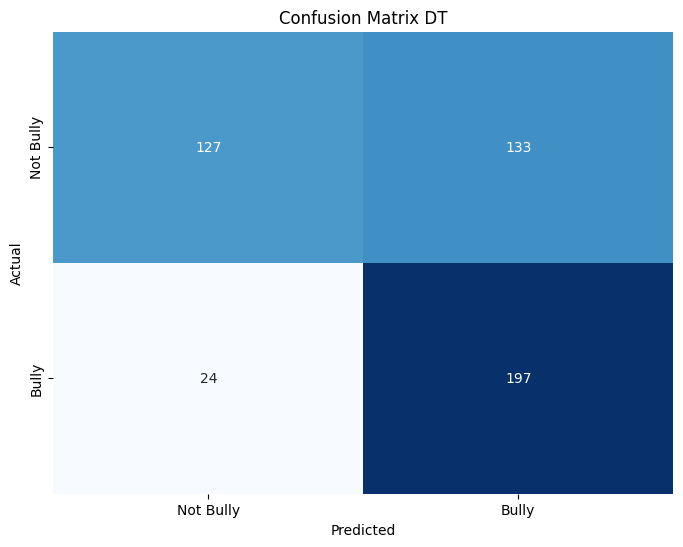

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Define the parameter grid for grid search
param_grid = {
    'max_depth': [None, 10, 20, 30],  
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a Decision Tree classifier
dt_classifier = DecisionTreeClassifier()

# Create a GridSearchCV object
grid_search = GridSearchCV(dt_classifier, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train_tfidf, y_train)

# Get the best estimator from the grid search
best_dt_classifier = grid_search.best_estimator_

# Make predictions on the validation set
y_val_pred = best_dt_classifier.predict(X_val_tfidf)

# Evaluate performance
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred, average='weighted')
recall = recall_score(y_val, y_val_pred, average='weighted')
f1 = f1_score(y_val, y_val_pred, average='weighted')

# Print the results
print("Decision Tree Model Performance:")
print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Plot Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Bully', 'Bully'],
            yticklabels=['Not Bully', 'Bully'])
plt.title('Confusion Matrix DT')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


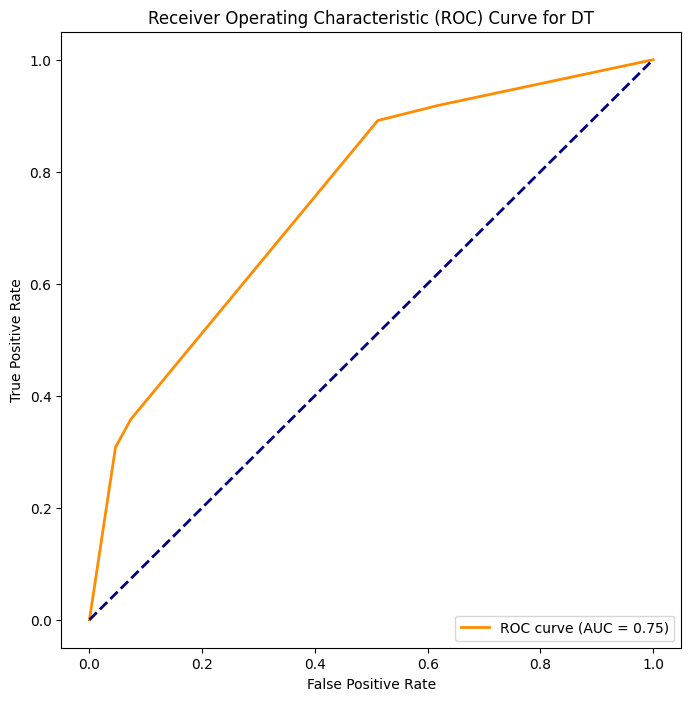

AUC (DT): 0.7525670031326139


In [42]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class
y_val_prob = best_dt_classifier.predict_proba(X_val_tfidf)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_val, y_val_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for DT')
plt.legend(loc='lower right')
plt.show()

print("AUC (DT):", roc_auc)


SVM Model Performance:
Best Parameters: {'estimator__C': 1, 'estimator__gamma': 'scale', 'estimator__kernel': 'rbf'}
Accuracy: 0.8045738045738046
Precision: 0.8120945992799541
Recall: 0.8045738045738046
F1 Score: 0.8047630531548355


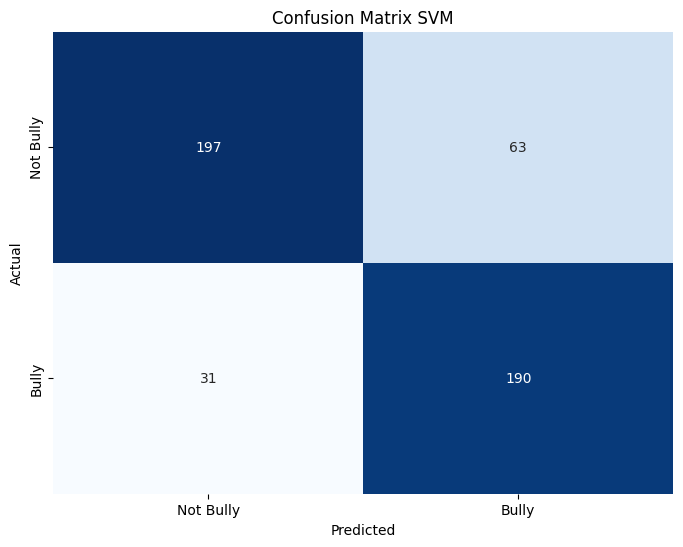

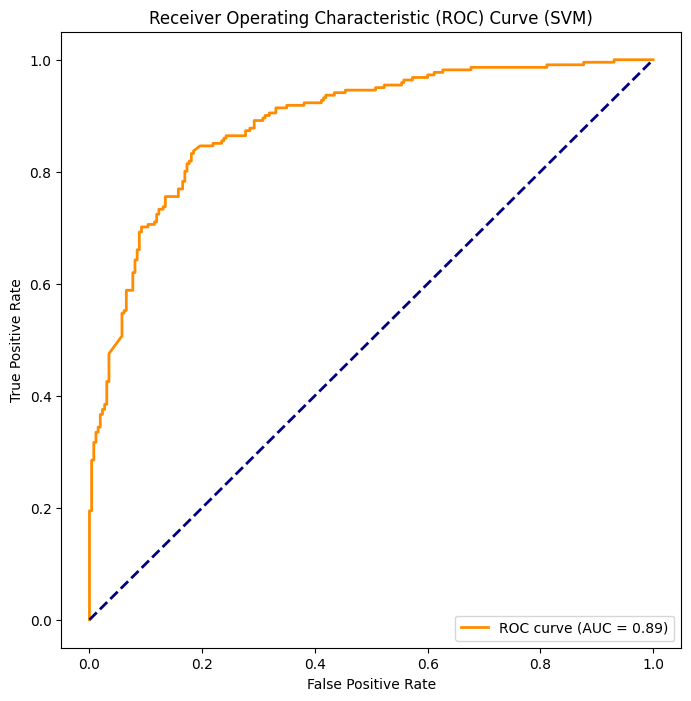

AUC (SVM): 0.8892272885485556


In [43]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt

# Define the parameter grid for grid search
param_grid = {
    'estimator__C': [0.1, 1, 10],  # C parameter for SVC
    'estimator__kernel': ['linear', 'rbf'],
    'estimator__gamma': ['scale', 'auto']
}

# Create an SVM classifier with probability estimates
svm_classifier = SVC(probability=True)

# Wrap the SVM classifier with OneVsRestClassifier
ovr_classifier = OneVsRestClassifier(svm_classifier)

# Create a GridSearchCV object
grid_search = GridSearchCV(ovr_classifier, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train_tfidf, y_train)

# Get the best estimator from the grid search
best_svm_classifier = grid_search.best_estimator_

# Make predictions on the validation set
y_val_pred = best_svm_classifier.predict(X_val_tfidf)
y_val_prob_svm = best_svm_classifier.predict_proba(X_val_tfidf)[:, 1]

# Evaluate performance
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred, average='weighted')
recall = recall_score(y_val, y_val_pred, average='weighted')
f1 = f1_score(y_val, y_val_pred, average='weighted')

# Print the results
print("SVM Model Performance:")
print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Plot Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Bully', 'Bully'],
            yticklabels=['Not Bully', 'Bully'])
plt.title('Confusion Matrix SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC curve and AUC
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_val, y_val_prob_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc_svm))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (SVM)')
plt.legend(loc='lower right')
plt.show()

print("AUC (SVM):", roc_auc_svm)


Logistic Regression Model Performance:
Best Parameters: {'C': 10}
Accuracy: 0.8128898128898129
Precision: 0.8148342426494996
Recall: 0.8128898128898129
F1 Score: 0.813173637544347


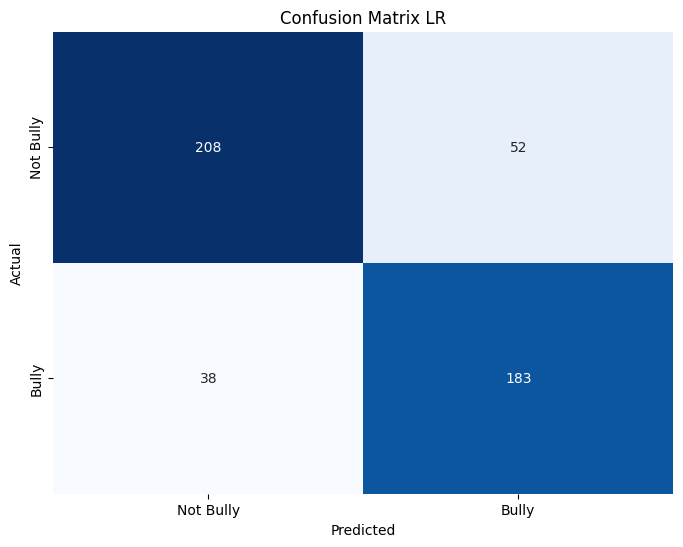

In [51]:
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define the parameter grid for grid search
param_grid = {
    'C': [0.1, 1, 10],
    
}

# Create a Logistic Regression classifier
lr_classifier = LogisticRegression(max_iter=1000)  # max_iter is increased for convergence

# Create a GridSearchCV object
grid_search = GridSearchCV(lr_classifier, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train_tfidf, y_train)

# Get the best estimator from the grid search
best_lr_classifier = grid_search.best_estimator_


# Make predictions on the validation set
y_val_pred = best_lr_classifier.predict(X_val_tfidf)

# Evaluate performance
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred, average='weighted')
recall = recall_score(y_val, y_val_pred, average='weighted')
f1 = f1_score(y_val, y_val_pred, average='weighted')

# Print the results
print("Logistic Regression Model Performance:")
print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Plot Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Bully', 'Bully'],
            yticklabels=['Not Bully', 'Bully'])
plt.title('Confusion Matrix LR')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [53]:
import pickle

model_filename = 'Model/logistic_regression_model.sav'
with open(model_filename, 'wb') as filehandler:
    pickle.dump(best_lr_classifier, filehandler)

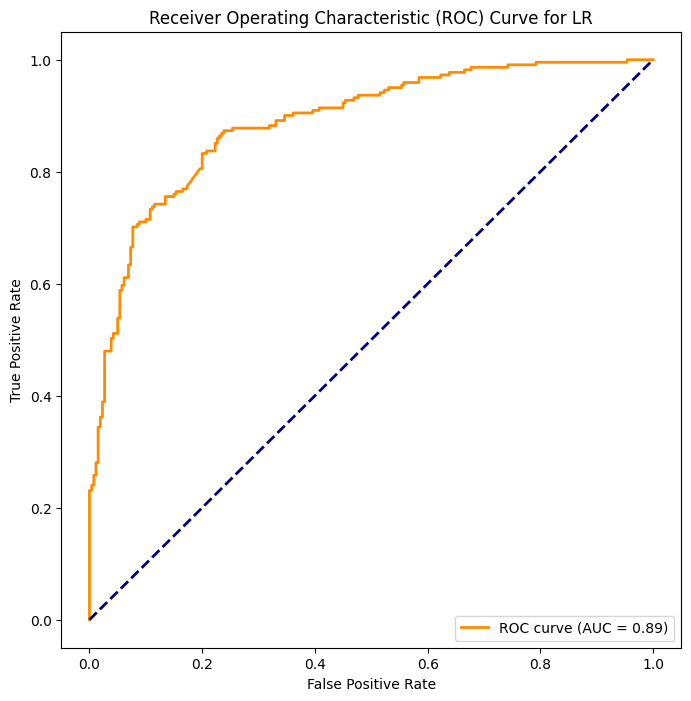

AUC (LR): 0.8875739644970415


In [45]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class
y_val_prob = best_lr_classifier.predict_proba(X_val_tfidf)[:, 1]


# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_val, y_val_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for LR')
plt.legend(loc='lower right')
plt.show()

print("AUC (LR):", roc_auc)

Random Forest Model Performance:
Best Parameters: {'max_depth': None, 'n_estimators': 50}
Accuracy: 0.7650727650727651
Precision: 0.7727011933366646
Recall: 0.7650727650727651
F1 Score: 0.7652738483647378


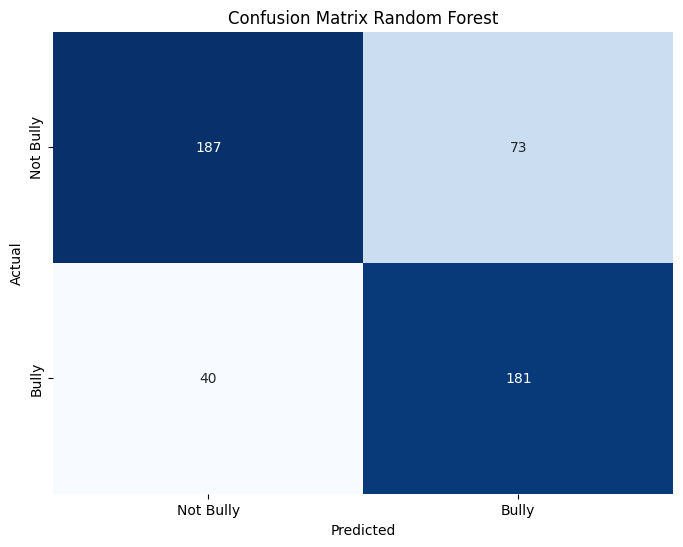

In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 200], 
    'max_depth': [None, 10, 20, 30], 
}

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier()

# Create a GridSearchCV object
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train_tfidf, y_train)

# Get the best estimator from the grid search
best_rf_classifier = grid_search.best_estimator_

# Make predictions on the validation set
y_val_pred = best_rf_classifier.predict(X_val_tfidf)

# Evaluate performance
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred, average='weighted')
recall = recall_score(y_val, y_val_pred, average='weighted')
f1 = f1_score(y_val, y_val_pred, average='weighted')

# Print the results
print("Random Forest Model Performance:")
print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Plot Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Bully', 'Bully'],
            yticklabels=['Not Bully', 'Bully'])
plt.title('Confusion Matrix Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

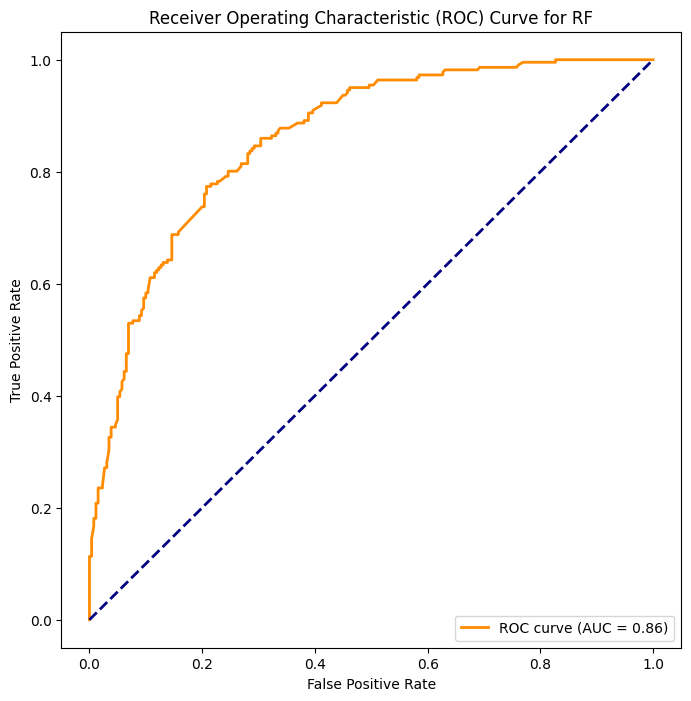

AUC (RF): 0.8591802993386704


In [47]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class
y_val_prob = best_rf_classifier.predict_proba(X_val_tfidf)[:, 1]


# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_val, y_val_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for RF')
plt.legend(loc='lower right')
plt.show()

print("AUC (RF):", roc_auc)